In [1]:
import numpy as np 
import pandas as pd
import os
import zipfile

# Input data files are available in the "../input/" directory
# For example, running this kernel will list the files in the input directory
print(os.listdir("../input/platesv2"))

with zipfile.ZipFile('../input/platesv2/plates.zip', 'r') as zip_file:
    zip_file.extractall('/kaggle/working')


print('After zip extraction:', os.listdir("/kaggle/working/"))

['plates.zip', 'sample_submission.csv']
After zip extraction: ['plates', '__notebook__.ipynb', '__MACOSX']


In [2]:
import shutil
from tqdm import tqdm

data_root = '/kaggle/working/plates/'
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

# This kernel distributes input images into training and validation data
# Each sixth image goes to validation data
# Train and validation directories contains 'cleaned' and 'dirty' folders for getting images label in the future

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
        
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        dest_dir = os.path.join(val_dir if i % 6 == 0 else train_dir, class_name) 
        
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 3970.80it/s]


In [3]:
!ls train/cleaned

0000.jpg  0003.jpg  0006.jpg  0011.jpg	0014.jpg  0018.jpg
0001.jpg  0004.jpg  0007.jpg  0012.jpg	0016.jpg  0019.jpg
0002.jpg  0005.jpg  0008.jpg  0013.jpg	0017.jpg


In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt
import time
import copy


# Here you see an augmentation - increasing the number of training images by transforming them
# When you get a Butch from the dataloader, the specified transformations are applied to each image
# Since transformations are random, the augmentation of the original image is random
# Therefore, in each epoch, we will learn from pseudo-new images
from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ImageFolder class returns tuple of file and name of its directory
train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 6
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True, 
                                               num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=False, 
                                               num_workers=batch_size)

In [5]:
len(train_dataloader), len(train_dataset)

(6, 34)

In [6]:
def show_image(input_tensor, title=''):
    '''
        This function allows to show an image presented as torch.Tensor class
    '''
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

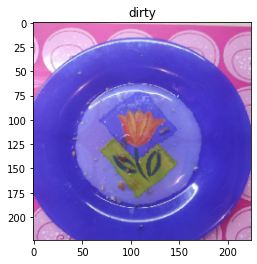

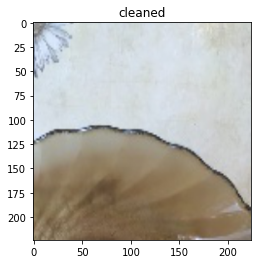

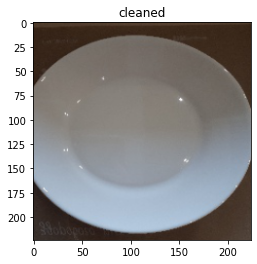

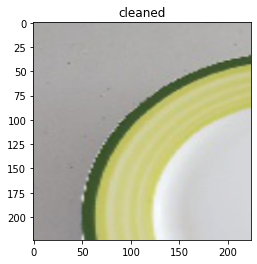

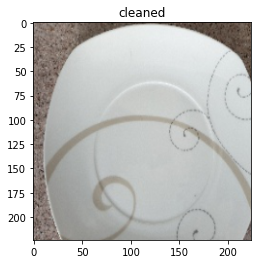

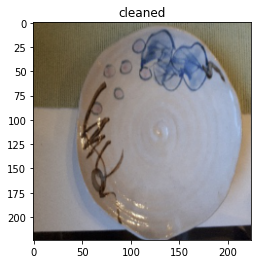

In [7]:
X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_image(x_item, title=class_names[y_item])

In [8]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()
            else: 
                dataloader = val_dataloader
                model.eval()
            
            running_loss = 0.
            running_acc = 0.
            
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()
                
            epoch_loss = running_loss/len(dataloader)
            epoch_acc = running_acc/len(dataloader)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [9]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=7,
                                            gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [10]:
train_model(model, loss, optimizer, scheduler, num_epochs=100)

Epoch 0/99:


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

train Loss: 0.8864 Acc: 0.4444



100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

val Loss: 0.7092 Acc: 0.5000
Epoch 1/99:



100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

train Loss: 0.7367 Acc: 0.4444



100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

val Loss: 0.5992 Acc: 0.5000
Epoch 2/99:



100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

train Loss: 0.7642 Acc: 0.4306



100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

val Loss: 0.4825 Acc: 0.8333
Epoch 3/99:



100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

train Loss: 0.6254 Acc: 0.7778



100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

val Loss: 0.4508 Acc: 0.8333
Epoch 4/99:



100%|██████████| 6/6 [00:01<00:00,  3.07it/s]

train Loss: 0.5826 Acc: 0.7083



100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

val Loss: 0.4271 Acc: 1.0000
Epoch 5/99:



100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

train Loss: 0.5970 Acc: 0.6806



100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

val Loss: 0.4015 Acc: 1.0000
Epoch 6/99:



100%|██████████| 6/6 [00:01<00:00,  3.09it/s]

train Loss: 0.5143 Acc: 0.8056



100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

val Loss: 0.3983 Acc: 1.0000
Epoch 7/99:



100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

train Loss: 0.5270 Acc: 0.8194



100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

val Loss: 0.4044 Acc: 0.8333
Epoch 8/99:



100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

train Loss: 0.5137 Acc: 0.8472



100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

val Loss: 0.3858 Acc: 0.8333
Epoch 9/99:



100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

train Loss: 0.4495 Acc: 0.8611



100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

val Loss: 0.3950 Acc: 0.8333
Epoch 10/99:



100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

train Loss: 0.5411 Acc: 0.7639



100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

val Loss: 0.3963 Acc: 0.8333
Epoch 11/99:



100%|██████████| 6/6 [00:01<00:00,  3.07it/s]

train Loss: 0.4724 Acc: 0.8889



100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

val Loss: 0.4138 Acc: 0.8333
Epoch 12/99:



100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

train Loss: 0.5856 Acc: 0.7361



100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

val Loss: 0.3948 Acc: 0.8333
Epoch 13/99:



100%|██████████| 6/6 [00:01<00:00,  3.08it/s]

train Loss: 0.5248 Acc: 0.7778



100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

val Loss: 0.4039 Acc: 0.8333
Epoch 14/99:



100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

train Loss: 0.4721 Acc: 0.8611



100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

val Loss: 0.3994 Acc: 0.8333
Epoch 15/99:



100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

train Loss: 0.5433 Acc: 0.6667



100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

val Loss: 0.4035 Acc: 0.8333
Epoch 16/99:



100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

train Loss: 0.5753 Acc: 0.7083



100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

val Loss: 0.3885 Acc: 0.8333
Epoch 17/99:



100%|██████████| 6/6 [00:01<00:00,  3.08it/s]

train Loss: 0.5145 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

val Loss: 0.3797 Acc: 0.8333
Epoch 18/99:



100%|██████████| 6/6 [00:02<00:00,  2.65it/s]

train Loss: 0.5034 Acc: 0.9028



100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

val Loss: 0.3846 Acc: 0.8333
Epoch 19/99:



100%|██████████| 6/6 [00:02<00:00,  2.92it/s]

train Loss: 0.5182 Acc: 0.7778



100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

val Loss: 0.3746 Acc: 0.8333
Epoch 20/99:



100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

train Loss: 0.5017 Acc: 0.7778



100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

val Loss: 0.3919 Acc: 0.8333
Epoch 21/99:



100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

train Loss: 0.5462 Acc: 0.7778



100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

val Loss: 0.3972 Acc: 0.8333
Epoch 22/99:



100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

train Loss: 0.5527 Acc: 0.7361



100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

val Loss: 0.3887 Acc: 0.8333
Epoch 23/99:



100%|██████████| 6/6 [00:02<00:00,  2.96it/s]

train Loss: 0.5075 Acc: 0.7917



100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

val Loss: 0.3904 Acc: 0.8333
Epoch 24/99:



100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

train Loss: 0.5046 Acc: 0.7639



100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

val Loss: 0.3793 Acc: 1.0000
Epoch 25/99:



100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

train Loss: 0.5482 Acc: 0.6944



100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

val Loss: 0.3909 Acc: 1.0000
Epoch 26/99:



100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

train Loss: 0.5904 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

val Loss: 0.3769 Acc: 1.0000
Epoch 27/99:



100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

train Loss: 0.5563 Acc: 0.7778



100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

val Loss: 0.3940 Acc: 0.8333
Epoch 28/99:



100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

train Loss: 0.5509 Acc: 0.8472



100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

val Loss: 0.3891 Acc: 0.8333
Epoch 29/99:



100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

train Loss: 0.5294 Acc: 0.7778



100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

val Loss: 0.3974 Acc: 0.8333
Epoch 30/99:



100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

train Loss: 0.5086 Acc: 0.7639



100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

val Loss: 0.4044 Acc: 0.8333
Epoch 31/99:



100%|██████████| 6/6 [00:01<00:00,  3.08it/s]

train Loss: 0.4662 Acc: 0.9028



100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

val Loss: 0.4124 Acc: 0.8333
Epoch 32/99:



100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

train Loss: 0.4830 Acc: 0.8333



100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

val Loss: 0.3895 Acc: 0.8333
Epoch 33/99:



100%|██████████| 6/6 [00:01<00:00,  3.07it/s]

train Loss: 0.5388 Acc: 0.7222



100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

val Loss: 0.3912 Acc: 0.8333
Epoch 34/99:



100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

train Loss: 0.5524 Acc: 0.6389



100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

val Loss: 0.3868 Acc: 0.8333
Epoch 35/99:



100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

train Loss: 0.5165 Acc: 0.7639



100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

val Loss: 0.3951 Acc: 0.8333
Epoch 36/99:



100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

train Loss: 0.5248 Acc: 0.7917



100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

val Loss: 0.3805 Acc: 0.8333
Epoch 37/99:



100%|██████████| 6/6 [00:01<00:00,  3.09it/s]

train Loss: 0.5219 Acc: 0.8194



100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

val Loss: 0.3881 Acc: 0.8333
Epoch 38/99:



100%|██████████| 6/6 [00:01<00:00,  3.09it/s]

train Loss: 0.4958 Acc: 0.8472



100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

val Loss: 0.3876 Acc: 0.8333
Epoch 39/99:



100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

train Loss: 0.4794 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

val Loss: 0.4035 Acc: 0.8333
Epoch 40/99:



100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

train Loss: 0.5088 Acc: 0.7778



100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

val Loss: 0.3986 Acc: 0.8333
Epoch 41/99:



100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

train Loss: 0.4945 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

val Loss: 0.3857 Acc: 0.8333
Epoch 42/99:



100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

train Loss: 0.5228 Acc: 0.8056



100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

val Loss: 0.4127 Acc: 0.8333
Epoch 43/99:



100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

train Loss: 0.5485 Acc: 0.7639



100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

val Loss: 0.3959 Acc: 0.8333
Epoch 44/99:



100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

train Loss: 0.4878 Acc: 0.7917



100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

val Loss: 0.3934 Acc: 0.8333
Epoch 45/99:



100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

train Loss: 0.5291 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

val Loss: 0.3924 Acc: 0.8333
Epoch 46/99:



100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

train Loss: 0.4693 Acc: 0.8333



100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

val Loss: 0.4156 Acc: 0.8333
Epoch 47/99:



100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

train Loss: 0.4982 Acc: 0.8333



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

val Loss: 0.3984 Acc: 0.8333
Epoch 48/99:



100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

train Loss: 0.4797 Acc: 0.9167



100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

val Loss: 0.4016 Acc: 0.8333
Epoch 49/99:



100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

train Loss: 0.5226 Acc: 0.7639



100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

val Loss: 0.3900 Acc: 0.8333
Epoch 50/99:



100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

train Loss: 0.4732 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

val Loss: 0.4033 Acc: 0.8333
Epoch 51/99:



100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

train Loss: 0.4915 Acc: 0.7778



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

val Loss: 0.3884 Acc: 0.8333
Epoch 52/99:



100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

train Loss: 0.4771 Acc: 0.8333



100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

val Loss: 0.3860 Acc: 0.8333
Epoch 53/99:



100%|██████████| 6/6 [00:01<00:00,  3.07it/s]

train Loss: 0.5667 Acc: 0.7361



100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

val Loss: 0.4008 Acc: 0.8333
Epoch 54/99:



100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

train Loss: 0.5551 Acc: 0.6944



100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

val Loss: 0.3888 Acc: 0.8333
Epoch 55/99:



100%|██████████| 6/6 [00:01<00:00,  3.09it/s]

train Loss: 0.4876 Acc: 0.8333



100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

val Loss: 0.4028 Acc: 0.8333
Epoch 56/99:



100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

train Loss: 0.4697 Acc: 0.8472



100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

val Loss: 0.4013 Acc: 0.8333
Epoch 57/99:



100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

train Loss: 0.4625 Acc: 0.8611



100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

val Loss: 0.4042 Acc: 0.8333
Epoch 58/99:



100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

train Loss: 0.4577 Acc: 0.8611



100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

val Loss: 0.4110 Acc: 0.8333
Epoch 59/99:



100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

train Loss: 0.5316 Acc: 0.8333



100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

val Loss: 0.3933 Acc: 1.0000
Epoch 60/99:



100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

train Loss: 0.5340 Acc: 0.7361



100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

val Loss: 0.3964 Acc: 0.8333
Epoch 61/99:



100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

train Loss: 0.5851 Acc: 0.6667



100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

val Loss: 0.4135 Acc: 0.8333
Epoch 62/99:



100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

train Loss: 0.4833 Acc: 0.7361



100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

val Loss: 0.4121 Acc: 0.8333
Epoch 63/99:



100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

train Loss: 0.5392 Acc: 0.7778



100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

val Loss: 0.4076 Acc: 0.8333
Epoch 64/99:



100%|██████████| 6/6 [00:01<00:00,  3.00it/s]

train Loss: 0.4961 Acc: 0.8194



100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

val Loss: 0.4097 Acc: 0.8333
Epoch 65/99:



100%|██████████| 6/6 [00:02<00:00,  3.00it/s]

train Loss: 0.4718 Acc: 0.7917



100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

val Loss: 0.4081 Acc: 0.8333
Epoch 66/99:



100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

train Loss: 0.4394 Acc: 0.8611



100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

val Loss: 0.4008 Acc: 0.8333
Epoch 67/99:



100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

train Loss: 0.4590 Acc: 0.7917



100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

val Loss: 0.4061 Acc: 0.8333
Epoch 68/99:



100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

train Loss: 0.5528 Acc: 0.7083



100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

val Loss: 0.4049 Acc: 0.8333
Epoch 69/99:



100%|██████████| 6/6 [00:02<00:00,  2.75it/s]

train Loss: 0.5141 Acc: 0.7361



100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

val Loss: 0.3980 Acc: 0.8333
Epoch 70/99:



100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

train Loss: 0.5048 Acc: 0.8056



100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

val Loss: 0.4228 Acc: 0.8333
Epoch 71/99:



100%|██████████| 6/6 [00:02<00:00,  3.00it/s]

train Loss: 0.5299 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

val Loss: 0.4103 Acc: 0.8333
Epoch 72/99:



100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

train Loss: 0.4731 Acc: 0.8194



100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

val Loss: 0.4092 Acc: 0.8333
Epoch 73/99:



100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

train Loss: 0.5406 Acc: 0.8333



100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

val Loss: 0.3955 Acc: 0.8333
Epoch 74/99:



100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

train Loss: 0.5034 Acc: 0.7778



100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

val Loss: 0.3716 Acc: 1.0000
Epoch 75/99:



100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

train Loss: 0.5525 Acc: 0.7361



100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

val Loss: 0.3857 Acc: 1.0000
Epoch 76/99:



100%|██████████| 6/6 [00:02<00:00,  2.96it/s]

train Loss: 0.5247 Acc: 0.7917



100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

val Loss: 0.3865 Acc: 0.8333
Epoch 77/99:



100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

train Loss: 0.4134 Acc: 0.9444



100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

val Loss: 0.4003 Acc: 0.8333
Epoch 78/99:



100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

train Loss: 0.4617 Acc: 0.9167



100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

val Loss: 0.3935 Acc: 0.8333
Epoch 79/99:



100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

train Loss: 0.5041 Acc: 0.7778



100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

val Loss: 0.4033 Acc: 0.8333
Epoch 80/99:



100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

train Loss: 0.4488 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

val Loss: 0.4035 Acc: 0.8333
Epoch 81/99:



100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

train Loss: 0.4547 Acc: 0.8889



100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

val Loss: 0.3862 Acc: 0.8333
Epoch 82/99:



100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

train Loss: 0.5367 Acc: 0.7361



100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

val Loss: 0.3860 Acc: 0.8333
Epoch 83/99:



100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

train Loss: 0.5493 Acc: 0.8333



100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

val Loss: 0.3763 Acc: 0.8333
Epoch 84/99:



100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

train Loss: 0.5337 Acc: 0.7639



100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

val Loss: 0.3635 Acc: 1.0000
Epoch 85/99:



100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

train Loss: 0.5793 Acc: 0.7639



100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

val Loss: 0.3703 Acc: 0.8333
Epoch 86/99:



100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

train Loss: 0.4697 Acc: 0.8889



100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

val Loss: 0.3963 Acc: 0.8333
Epoch 87/99:



100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

train Loss: 0.6039 Acc: 0.7222



100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

val Loss: 0.3948 Acc: 0.8333
Epoch 88/99:



100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

train Loss: 0.5775 Acc: 0.6944



100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

val Loss: 0.3869 Acc: 0.8333
Epoch 89/99:



100%|██████████| 6/6 [00:02<00:00,  2.96it/s]

train Loss: 0.5175 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

val Loss: 0.3782 Acc: 0.8333
Epoch 90/99:



100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

train Loss: 0.5227 Acc: 0.7361



100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

val Loss: 0.3887 Acc: 0.8333
Epoch 91/99:



100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

train Loss: 0.5643 Acc: 0.7222



100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

val Loss: 0.3860 Acc: 1.0000
Epoch 92/99:



100%|██████████| 6/6 [00:02<00:00,  2.96it/s]

train Loss: 0.5056 Acc: 0.7361



100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

val Loss: 0.3935 Acc: 0.8333
Epoch 93/99:



100%|██████████| 6/6 [00:02<00:00,  2.96it/s]

train Loss: 0.5937 Acc: 0.6389



100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

val Loss: 0.3979 Acc: 0.8333
Epoch 94/99:



100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

train Loss: 0.5068 Acc: 0.8333



100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

val Loss: 0.4071 Acc: 0.8333
Epoch 95/99:



100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

train Loss: 0.5231 Acc: 0.8472



100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

val Loss: 0.3881 Acc: 0.8333
Epoch 96/99:



100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

train Loss: 0.5466 Acc: 0.6944



100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

val Loss: 0.3845 Acc: 1.0000
Epoch 97/99:



100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

train Loss: 0.5207 Acc: 0.7639



100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

val Loss: 0.3987 Acc: 0.8333
Epoch 98/99:



100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

train Loss: 0.4631 Acc: 0.9167



100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

val Loss: 0.4199 Acc: 0.8333
Epoch 99/99:



100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

train Loss: 0.4564 Acc: 0.8056



100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

val Loss: 0.4139 Acc: 0.8333


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'),
                os.path.join(test_dir,'unknown'))

'test/unknown'

In [12]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=batch_size, 
                                              shuffle=False, 
                                              num_workers=0)

In [13]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [14]:
model.eval()
test_predictions = []

test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 124/124 [00:35<00:00,  3.49it/s]


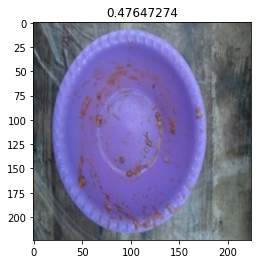

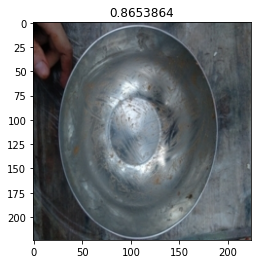

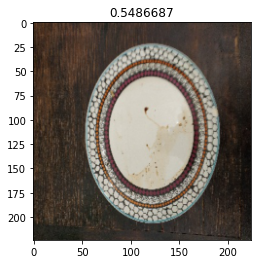

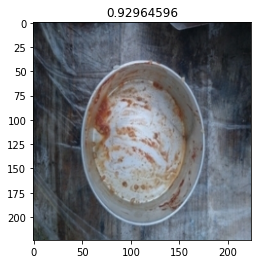

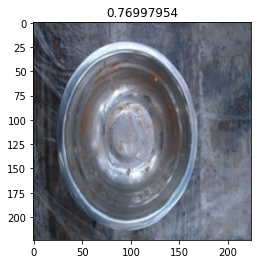

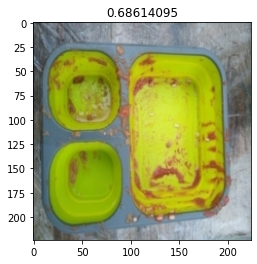

In [15]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_image(img, title=pred)

In [16]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 
                                        'label': test_predictions})

submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,cleaned
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [17]:
submission_df.to_csv('submission.csv')

In [18]:
!rm -rf train val test